# The Askeladden Algorithm - GridSearch <a class="tocSkip">

## W207 | Applied Machine Learning | Spring 2019<a class="tocSkip">

### Team Troll Trappers: Laura Pintos, Ramiro Cadavid, and Anna Jacobson<a class="tocSkip">

# Import data

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [11]:
df = pd.read_csv("news_tweets_big.csv", index_col=0)

d = {'real':0, 'troll':1}
df['category'] = df['category'].map(d)

my_df = pd.DataFrame(df,columns=['tweet_text'])
my_df['target'] = df.category

x = my_df.tweet_text
y = my_df.target
seed = 2019

x_train, x_dev_and_test, y_train, y_dev_and_test = train_test_split(x, y, test_size=0.4, random_state=seed)
x_dev, x_test, y_dev, y_test = train_test_split(x_dev_and_test, y_dev_and_test, test_size=0.5, random_state=seed)
targets = ['real','troll']

print('training data shape:', x_train.shape)
print('development data shape:', x_dev.shape)
print('test data shape:', x_test.shape)
print('labels names:', targets)

training data shape: (190323,)
development data shape: (63441,)
test data shape: (63442,)
labels names: ['real', 'troll']


# GridSearchCV

**Define functions**

In [91]:
def grid_search(train_data, train_labels, clf, grid, max_score, cv):
    # Define pipeline
    pipeline = Pipeline([('vectorizer', TfidfVectorizer()),
                         ('clf', clf)])
    
    # Fit GridSearch
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    grid_search = GridSearchCV(pipeline, grid, cv=cv, n_jobs=3, verbose=1,
                              scoring=scoring, refit=max_score)
    grid_search.fit(train_data, train_labels)    
    
    # Print best results
    print("Best {0}: {1:.3f}".format(max_score, grid_search.best_score_))
    print("\nBest parameters:")
    for param_name in grid_search.best_params_.keys():
        print('{0}: {1}'.format(param_name, grid_search.best_params_[param_name]))
        
    return grid_search


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

**Fit GridSearchCV for logistic regression**

Test grid

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  4.0min finished


Best accuracy: 0.886

Best parameters:
clf__C: 1.8
clf__fit_intercept: True
clf__multi_class: multinomial
clf__penalty: l2
clf__random_state: 2019
clf__solver: saga
vectorizer__analyzer: word
vectorizer__max_df: 1.0
vectorizer__max_features: 100000
vectorizer__ngram_range: (1, 2)
vectorizer__stop_words: None
vectorizer__token_pattern: \b\w+\b
vectorizer__use_idf: False

Accuracy (dev set) = 0.8878


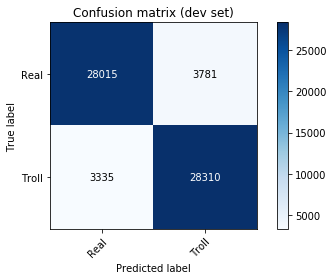

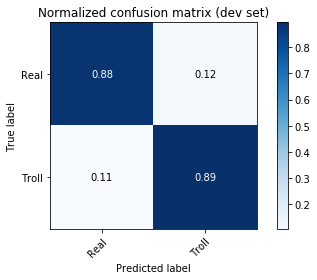

In [102]:
"""
Find best model
"""

grid = {'vectorizer__max_df': [1.0],
        'vectorizer__max_features': [100000],
        'vectorizer__stop_words': [None],
        'vectorizer__token_pattern': [r'\b\w+\b'],
        'vectorizer__ngram_range': [(1, 2)],
        'vectorizer__analyzer': ['word'],
        'vectorizer__use_idf': [False],
        'clf__fit_intercept': [True],
        'clf__penalty': ['l2'],
        'clf__solver': ['saga'],
        'clf__multi_class': ['multinomial'],
        'clf__C': [1.8],
        'clf__random_state': [2019]}

clf_gs = grid_search(x_train, y_train, LogisticRegression(), grid, 'accuracy', 10)

"""
Development set accuracy
"""

pred_dev = clf_gs.predict(x_dev)
acc_dev = accuracy_score(y_dev, pred_dev)
print('\nAccuracy (dev set) = {:.4f}'.format(acc_dev))

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_dev, pred_dev, classes=['Real', 'Troll'],
                      title='Confusion matrix (dev set)')

# Plot normalized confusion matrix
plot_confusion_matrix(y_dev, pred_dev, classes=['Real', 'Troll'], normalize=True,
                      title='Normalized confusion matrix (dev set)')

Full grid

In [105]:
"""
Find best model
"""

grid = {'vectorizer__max_df': [float(i) for i in np.arange(0, 1.01, 0.25)],
        'vectorizer__max_features': np.append([10000], np.arange(100000, 1000000, 200000)),
        'vectorizer__stop_words': [None],
        'vectorizer__ngram_range': [(1, 2), (1, 3)],
        'vectorizer__analyzar': ['word'],
        'vectorizer__use_idf': [True, False],
        'clf_fit_intercept': [True, False],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['saga'],
        'clf__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 100, 1000],
        'clf__random_state': [2019]}

clf_gs = grid_search(x_train, y_train, LogisticRegression(), grid, 'accuracy', 5)

"""
Development set accuracy
"""

pred_dev = clf_gs.predict(x_dev)
acc_dev = accuracy_score(y_dev, pred_dev)
print('\nAccuracy (dev set) = {:.4f}'.format(acc_dev))

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_dev, pred_dev, classes=['Real', 'Troll'],
                      title='Confusion matrix (dev set)')

# Plot normalized confusion matrix
plot_confusion_matrix(y_dev, pred_dev, classes=['Real', 'Troll'], normalize=True,
                      title='Normalized confusion matrix (dev set)')

Fine grained grid

# Store/retrieve models

Store model

In [ ]:
# Store GridSearchCV object
joblib.dump(clf_gs, 'Models/logreg_gscv.pkl', compress=1, protocol=pickle.HIGHEST_PROTOCOL)

# Store best estimator
joblib.dump(clf_gs.best_estimator_, 'Models/logreg_gscv_best.pkl', protocol=pickle.HIGHEST_PROTOCOL)

Retrieve model

In [ ]:
# Retrieve GridSearchCV object
clf_gs = joblib.load('Models/logreg_gscv.pkl')

#Retrieve best estimator
clf_best = joblib.load('Models/logreg_gscv_best.pkl')